# ml lab4

In [1]:
import numpy as np
import pandas as pd

import scipy.optimize as opt
import scipy.io

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### 1. read data

In [14]:
data = scipy.io.loadmat('data/ex4data1.mat')

x = np.array(data['X'])
y = np.squeeze(data['y'])

np.place(y, y == 10, 0)
m, n = x.shape

num_labels = 10
input_layer_size = 400
hidden_layer_size = 25

print(f'x shape: {x.shape}\ny size:\t{y.size}')

x shape: (5000, 400)
y size:	5000


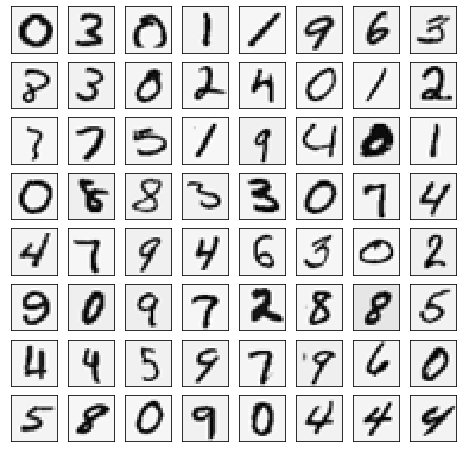

In [15]:
subplots = 64
draw_seed = np.random.randint(low=0, high=m, size=subplots)
draw_rows = x[draw_seed]
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
    data = np.reshape(draw_rows[i], (20, 20), order='F')
    axi.imshow(data, cmap='binary')
    axi.set(xticks=[], yticks=[])

plt.show()

### 2. read weights

In [16]:
weights = scipy.io.loadmat('data/ex4weights.mat')
theta1, theta2 = weights['Theta1'], weights['Theta2']
theta2 = np.roll(theta2, 1, axis=0)

print(f'Θ1 shape:\t{theta1.shape}\nΘ2 shape:\t{theta2.shape}')

Θ1 shape:	(25, 401)
Θ2 shape:	(10, 26)


> (input layer `400` nodes) -> (hidden layer `25` nodes) -> (output layer `10` nodes)

### 3. forward propagation + sigmoid

In [18]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def predict(X, theta1, theta2):
    m = X.shape[0]
    X = np.hstack((np.ones((m, 1)), X))
    a1 = sigmoid(X.dot(theta1.T))
    a1 = np.hstack((np.ones((m, 1)), a1))  # hidden layer
    a2 = sigmoid(a1.dot(theta2.T))  # output layer
    return np.argmax(a2, axis=1)

### 4. train accuracy

In [86]:
LOG_REG_ACCURACY = 94.74000000000001

def get_accuracy(theta1, theta2):
    p = predict(x, theta1, theta2)
    return np.mean(p == y) * 100

accuracy = get_accuracy(theta1, theta2)
print(f'Training accuracy: {accuracy}%')
print(f'On {accuracy - LOG_REG_ACCURACY:.2f}% better than logistic regression')

Training accuracy: 97.52%
On 2.78% better than logistic regression


### 5. one hot encoding

In [27]:
y_matrix = np.eye(num_labels)[y]

### 6. cost function

In [59]:
a1 = np.hstack([np.ones((m, 1)), x])

a2 = sigmoid(a1.dot(theta1.T))
a2 = np.hstack([np.ones((a2.shape[0], 1)), a2])

a3 = sigmoid(a2.dot(theta2.T))

def calc_cost(h, y_matrix, m):
    return (-1 / m) * np.sum((np.log(h) * y_matrix) + np.log(1 - h) * (1 - y_matrix))

print(f'Cost:\t{calc_cost(a3, y_matrix, m)}')

Cost:	0.2876291651613189


### 7. cost L2-regularization

In [61]:
def get_reg_term(theta1, theta2, m, lambda_=1):
    return (lambda_ / (2 * m)) * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:])))
print(f'Regularized Cost:\t{cost + get_reg_term(theta1, theta2, m)}')

Regularized Cost:	0.38376985909092365


### 8. sigmoid gradient

In [62]:
def sigmoid_gradient(X):
    sigm = 1 / (1 + np.exp(-X))
    return sigm * (1 - sigm)

sigmoid_gradient(0), sigmoid_gradient(100)

(0.25, 0.0)

> should be (0.25, 0)

### 9. random weights initialization

In [88]:
def init_weights_rand(l_in, l_out, epsilon=0.12):
    return np.random.rand(l_out, 1 + l_in) * 2 * epsilon - epsilon

initial_theta1 = init_weights_rand(input_layer_size, hidden_layer_size)
initial_theta2 = init_weights_rand(hidden_layer_size, num_labels)
initial_theta1.shape, initial_theta2.shape

((25, 401), (10, 26))

### 10. backward propagation

In [92]:
def get_thetas(nn_params, input_layer_size, hidden_layer_size, num_labels):
    theta1 = np.reshape(
        nn_params[:hidden_layer_size * (input_layer_size + 1)],
        (hidden_layer_size, (input_layer_size + 1))
    )
    theta2 = np.reshape(
        nn_params[(hidden_layer_size * (input_layer_size + 1)):],
        (num_labels, (hidden_layer_size + 1))
    )
    return theta1, theta2


def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_=0.0):
    theta1, theta2 = get_thetas(nn_params, input_layer_size, hidden_layer_size, num_labels)
    m = y.size
    
    # forward propagation
    a1 = np.hstack([np.ones((m, 1)), X])
    a2 = sigmoid(a1.dot(theta1.T))
    a2 = np.hstack([np.ones((a2.shape[0], 1)), a2])
    a3 = sigmoid(a2.dot(theta2.T))
    
    # cost calculation
    y_matrix = y.reshape(-1)
    y_matrix = np.eye(num_labels)[y_matrix]
    J = calc_cost(a3, y_matrix, m) + get_reg_term(theta1, theta2, m, lambda_)
    
    # back propogation
    delta_3 = a3 - y_matrix
    delta_2 = delta_3.dot(theta2)[:, 1:] * sigmoid_gradient(a1.dot(theta1.T))
    delta1 = delta_2.T.dot(a1)
    delta2 = delta_3.T.dot(a2)
    
    # gradient regularization
    theta1_grad = (1 / m) * delta1
    theta1_grad[:, 1:] = theta1_grad[:, 1:] + (lambda_ / m) * theta1[:, 1:]
    theta2_grad = (1 / m) * delta2
    theta2_grad[:, 1:] = theta2_grad[:, 1:] + (lambda_ / m) * theta2[:, 1:]
    grad = np.concatenate([theta1_grad.ravel(), theta2_grad.ravel()])
    
    return J, grad

### 11. test gradient with `ε=10^-4`

In [93]:
def compute_numerical_gradient(J, theta, e=1e-4):
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        cost1, _ = J(theta - perturb[:, i])
        cost2, _ = J(theta + perturb[:, i])
        numgrad[i] = (cost2 - cost1) / (2 * e)
    return numgrad

In [94]:
def test_nn_gradients(lambda_=0.0):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # generate test data
    theta1 = init_weights_rand(hidden_layer_size - 1, input_layer_size + 1)
    theta2 = init_weights_rand(num_labels - 1, hidden_layer_size + 1)
    X = init_weights_rand(m - 1, input_layer_size)
    X = X.reshape(m, num_labels)
    y = np.arange(1, 1 + m) % num_labels
    
    # unroll parameters
    nn_params = np.concatenate([theta1.ravel(), theta2.ravel()])
    cost_func = lambda p: nn_cost_function(p, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)
    
    cost, grad = cost_func(nn_params)
    numgrad = compute_numerical_gradient(cost_func, nn_params)
    
    print('Numerical Gradient:\n', numgrad[:5].ravel())
    print('Analytical Gradient:\n', grad[:5].ravel())
    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    print('\nDiff:\t', diff)

test_nn_gradients()

Numerical Gradient:
 [ 0.01002531 -0.00033635 -0.00030924 -0.00070671 -0.00024677]
Analytical Gradient:
 [ 0.01002531 -0.00033635 -0.00030924 -0.00070671 -0.00024677]

Diff:	 4.539882294782546e-11


> Numerical Gradient and Analytical Gradient should be very similar

> With `e=1e-4` diff should be less than `1e-9`

### 12-13. test gradient with L2-regularization

In [95]:
test_nn_gradients(lambda_=1.0)

Numerical Gradient:
 [0.00627576 0.02235517 0.01705989 0.00180273 0.00468988]
Analytical Gradient:
 [0.00627576 0.02235517 0.01705989 0.00180273 0.00468988]

Diff:	 3.122096112171884e-11


### 14. train with gradient descent

In [96]:
def nn_gradient_descent(nn_params, cost_func, alpha, num_iters):
    j_history = []
    for i in range(0, num_iters):
        cost, grad = cost_func(nn_params)
        nn_params -= alpha * grad
        j_history.append(cost)

    return nn_params, j_history

In [97]:
initial_theta1 = init_weights_rand(input_layer_size, hidden_layer_size)
initial_theta2 = init_weights_rand(hidden_layer_size, num_labels)
initial_nn_params = np.concatenate([initial_theta1.ravel(), initial_theta2.ravel()])

cost_func = lambda p: nn_cost_function(p, input_layer_size, hidden_layer_size, num_labels, x, y, lambda_=1.0)
nn_params, costs = nn_gradient_descent(initial_nn_params, cost_func, alpha=0.5, num_iters=1000)

print(f'Gradient Descent Cost:\t{costs[-1]}')

Gradient Descent Cost:	0.5742122654294397


### 15. train accuracy

In [99]:
theta1, theta2 = get_thetas(nn_params, input_layer_size, hidden_layer_size, num_labels)
print(f'Training accuracy: {get_accuracy(theta1, theta2)}%')

Training accuracy: 93.4%


### 16. visualize hidden layer

In [103]:
def visualize_data(input, display_rows=5, display_cols=5):
    subplots = display_rows * display_cols
    fig, ax = plt.subplots(display_rows, display_cols, figsize=(10, 10))
    
    for i, axi in enumerate(ax.flat):
        data = np.reshape(input[i], (20, 20), order='F')
        axi.imshow(data, cmap='binary')
        axi.set(xticks=[], yticks=[])

    plt.show()

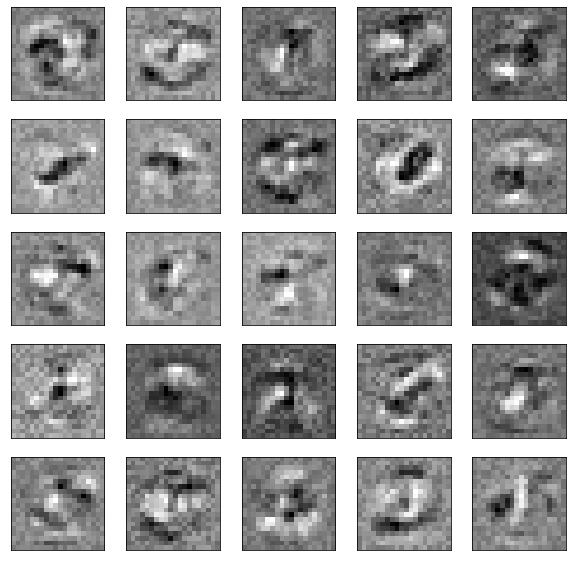

In [104]:
visualize_data(theta1[:, 1:])

### 17. optimize lambda

In [105]:
def test_lambda(lambda_):
    initial_theta1 = init_weights_rand(input_layer_size, hidden_layer_size)
    initial_theta2 = init_weights_rand(hidden_layer_size, num_labels)
    initial_nn_params = np.concatenate([initial_theta1.ravel(), initial_theta2.ravel()])
    
    cost_func = lambda p: nn_cost_function(p, input_layer_size, hidden_layer_size, num_labels, x, y, lambda_=lambda_)
    nn_params, costs = nn_gradient_descent(initial_nn_params, cost_func, alpha=0.5, num_iters=5000)

    theta1, theta2 = get_thetas(nn_params, input_layer_size, hidden_layer_size, num_labels)
    
    print(f'Lambda:\t{lambda_}')
    print(f'Cost:\t{costs[-1]}')
    print(f'Training accuracy: {get_accuracy(theta1, theta2)}%')

    visualize_data(theta1[:, 1:])

Lambda:	0
Cost:	0.18278464778554096
Training accuracy: 98.22%


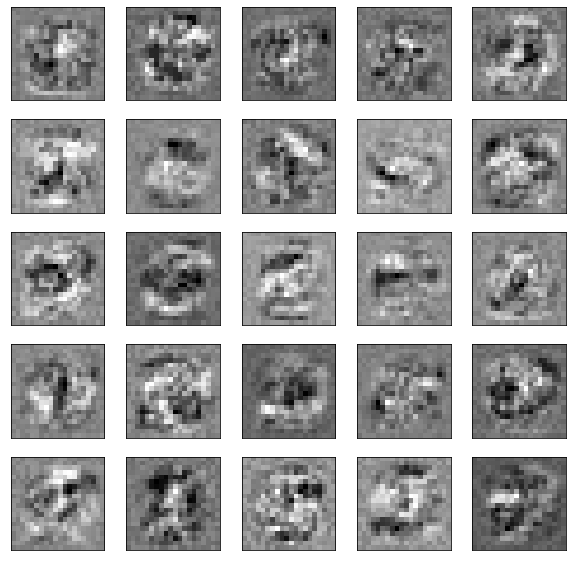

In [106]:
test_lambda(0)

Lambda:	1
Cost:	0.3738456250804313
Training accuracy: 97.74000000000001%


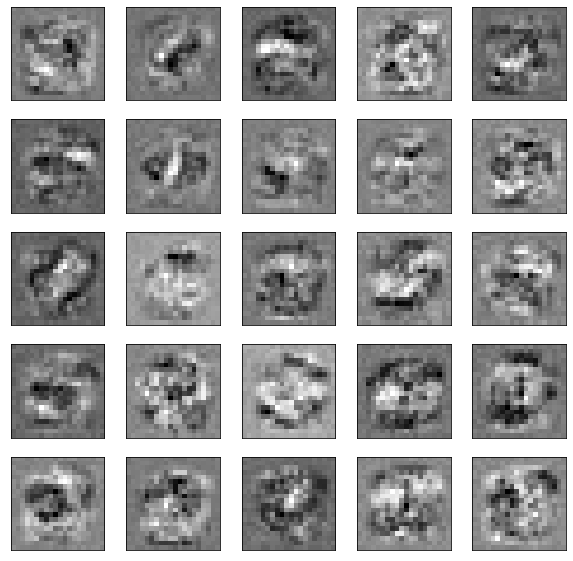

In [107]:
test_lambda(1)

Lambda:	50
Cost:	1.9472983729745628
Training accuracy: 88.92%


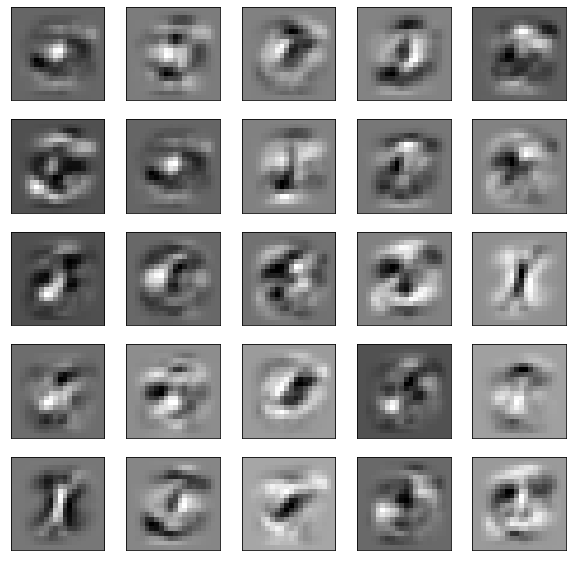

In [108]:
test_lambda(50)

> При увеличении параметра регуляризации изображения на скрытом слое размываются

### 18. conclusions

Была рассмотрена модель нейронной сети с 3 слоями. Построены функции стоимости и градиента. Визуализирован скрытый слой сети. С помощью алгоритма градиентного спуска получена точность распознования 93.4%.